<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/perceptron_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapt the Script that implements a neural network with PyTorch (over the iris or mnist datasets) code available in the Overview notebook such that it is implemented with TensorFlow instead of PyTorch. Adjust the parameters to try to obtain a global accuracy close to 90% for the MNIST dataset.

Each student should create a video (3' maximum) explaing which were the major changes that were made on the script and submit the video and the link to file in their GitHub repository where the modified script is available.

Submission deadline: Wednesday, April 10.

C:\Users\sofia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch [100/500], Train Loss: 0.1289, Test Loss: 1.6406
Epoch [200/500], Train Loss: 0.1404, Test Loss: 1.4632
Epoch [300/500], Train Loss: 0.1406, Test Loss: 1.4755
Epoch [400/500], Train Loss: 0.1279, Test Loss: 1.4832
Epoch [500/500], Train Loss: 0.1198, Test Loss: 1.4898


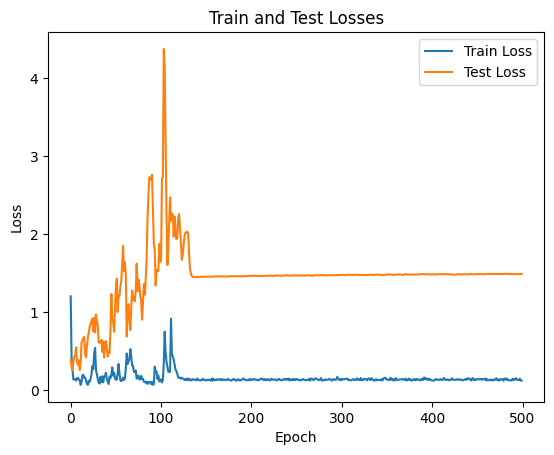

Accuracy on test set: 0.9194


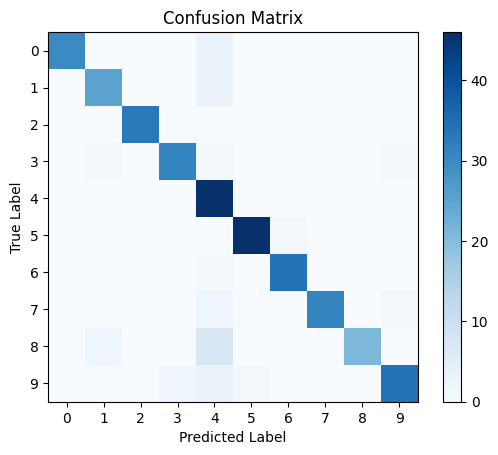

In [4]:
#@title Script that implements a neural network with PyTorch (over the iris or mnist datasets)
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

CREATE_CLASS=True # Create class from scratch; otherwise use nn.Sequential to create the class
SGD=False # SGD or Adam
IRIS=False # iris or mnist
SHOW=False # returns picture of digit for mnist

# Load Iris dataset
if IRIS:
    examples = load_iris()
else:
    examples = load_digits()  # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits; 1797 examples
    if SHOW:
        idx = np.random.randint(0, len(examples.target))
        print(examples.data[idx])
        print(examples.data[idx].reshape(8, 8))
        print(examples.target[idx])
        plt.matshow(examples.data[idx].reshape(8, 8), cmap=plt.cm.gray_r)
        plt.show()

X = examples.data
y = examples.target

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Convert numpy arrays to TensorFlow tensors (required data format for training NN)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_size = 16
output_size = len(examples.target_names)
batch_size=200
num_epochs = 500
# Optimizer specific options
learning_rate=0.1
regularization_param=0.001
momentum_param=0.9
# Dropout: if p>0
dropout_p=0 # During training, randomly zeroes some of the elements of the input tensor with probability p.

## Create dataloader which makes it easier to use mini batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor)).shuffle(buffer_size=1000).batch(batch_size)

## Neural Network model
if CREATE_CLASS:
    # Create model, first defining the class with a forward method
    class ThreeLayerNet(tf.keras.Model):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNet, self).__init__()
            self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu')
            self.dropout1 = tf.keras.layers.Dropout(dropout_p)
            self.fc2 = tf.keras.layers.Dense(hidden_size, activation='relu')
            self.dropout2 = tf.keras.layers.Dropout(dropout_p)
            self.fc3 = tf.keras.layers.Dense(output_size)
        def call(self, x):
            x = self.fc1(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            return x
    model = ThreeLayerNet(input_size, hidden_size, output_size)
else:
    # Or, in alternative, use tf.keras.Sequential
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(output_size)
    ])

####################################################################################################
## Define loss function and optimizer for raining model
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #suitable for multi-class classification problems with integer labels

if SGD:
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum_param,
                                        decay=regularization_param)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=regularization_param)

# Lists to store train and test losses
train_losses = []
test_losses = []

## Training the model
for epoch in range(num_epochs):
    train_loss = tf.keras.metrics.Mean()
    for x_batch, y_batch in train_ds:
        # Forward pass
        with tf.GradientTape() as tape:
            pred = model(x_batch)
            loss = criterion(y_batch, pred)

        # Backward pass and optimization
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)

    train_losses.append(train_loss.result())

    # Test the model
    test_loss = criterion(y_test_tensor, model(X_test_tensor))
    test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.result():.4f}, Test Loss: {test_loss:.4f}')


# Plotting train and test losses
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()

## Testing the model (evaluation)
predicted_logits = model(X_test_tensor)
predicted_labels = tf.argmax(predicted_logits, axis=1).numpy()
accuracy = accuracy_score(y_test_tensor, predicted_labels)
print(f'Accuracy on test set: {accuracy:.4f}')
cm = confusion_matrix(y_test_tensor, predicted_labels)
labels = np.unique(y_test_tensor)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()